In [1]:
import os

import time
from tqdm.notebook import tqdm

import numpy as np
import math

from pystencils.session import *
from lbmpy.session import *

from pystencils.simp import sympy_cse
from pystencils.boundaries import BoundaryHandling

from lbmpy.phasefield_allen_cahn.parameter_calculation import AllenCahnParameters
from lbmpy.phasefield_allen_cahn.contact_angle import ContactAngle
from lbmpy.phasefield_allen_cahn.kernel_equations import *

from lbmpy.advanced_streaming import LBMPeriodicityHandling
from lbmpy.boundaries import NoSlip, LatticeBoltzmannBoundaryHandling

If `pycuda` is installed the simulation automatically runs on GPU

In [2]:
try:
    import pycuda
except ImportError:
    pycuda = None
    gpu = False
    target = ps.Target.CPU
    print('No pycuda installed')

if pycuda:
    gpu = True
    target = ps.Target.GPU

No pycuda installed


# Gravity wave simulated with a phase-field model for immiscible fluids

## Geometry Setup

First of all the stencils for the phase-field LB step as well as the stencil for the hydrodynamic LB step are defined. According to the stencils the simulation runs either in 2D or 3D

In [3]:
stencil_phase = LBStencil(Stencil.D2Q9)
stencil_hydro = LBStencil(Stencil.D2Q9)
assert(stencil_hydro.D == stencil_phase.D)

dimensions = stencil_phase.D

In [4]:
# user defined input

Re = 10 # Reynolds number
domain_width = 50
fluid_depth = 0.5 * domain_width
amplitude = 0.01 * domain_width
relaxation_rate_heavy = 1.99
mobility = 0.02 # phase field mobility
interface_width = 5 # phase field interface width
density_heavy = 1.0 # density of heavy phase
density_ratio = 1000
density_light = density_heavy / density_ratio # density of light phase
kinematic_viscosity_ratio = 1

kinematic_viscosity_heavy = 1 / 3 * (1 / relaxation_rate_heavy - 0.5)
kinematic_viscosity_light = kinematic_viscosity_heavy / kinematic_viscosity_ratio
wavelength = domain_width
wavenumber = 2.0 * np.pi / domain_width
wave_frequency = Re * kinematic_viscosity_heavy / domain_width / amplitude # angular wave frequency
surface_tension = 0
gravitational_acceleration = - wave_frequency**2 / wavenumber / np.tanh(wavenumber * fluid_depth)
Pe = domain_width * amplitude * wave_frequency / mobility # Peclet number
Cn = interface_width / domain_width # Cahn number
dynamic_viscosity_heavy = kinematic_viscosity_heavy * density_heavy
relaxation_time_heavy = 3.0 * kinematic_viscosity_heavy
kinematic_viscosity_light = kinematic_viscosity_heavy / kinematic_viscosity_ratio
dynamic_viscosity_light = kinematic_viscosity_light * density_light
relaxation_time_light = 3.0 * kinematic_viscosity_light

timesteps = int(80 / wave_frequency)

data_extract_frequency = int(0.1 / wave_frequency)
vtk_output_frequency = int(1 / wave_frequency)
vtk_output_path = "vtk_out/gravity-wave"
vtk_base_directory = vtk_output_path.split("/")[0] # create directory for vtk-output if it does not yet exist
if not os.path.exists(vtk_base_directory):
    os.mkdir(os.getcwd() + "/" + vtk_base_directory)

domain_size = (domain_width, domain_width)
filename = "pf-re-" + str(Re) + "-resolution-" + str(domain_width) + ".txt"

print("timesteps =", timesteps)
print("Re =", Re)
print("Pe =", Pe)
print("Cn =", Cn)
print("domain_width =", domain_width)
print("fluid_depth =", fluid_depth)
print("amplitude =", amplitude)
print("relaxation_rate_heavy =", relaxation_rate_heavy)
print("mobility =", mobility)
print("interface_width =", interface_width)
print("density_heavy =", density_heavy)
print("density_light =", density_light)
print("density_ratio =", density_ratio)
print("kinematic_viscosity_heavy =", kinematic_viscosity_heavy)
print("kinematic_viscosity_light =", kinematic_viscosity_light)
print("kinematic_viscosity_ratio =", kinematic_viscosity_ratio)
print("dynamic_viscosity_heavy =", dynamic_viscosity_heavy)
print("dynamic_viscosity_light =", dynamic_viscosity_light)
print("dynamic_viscosity_ratio =", dynamic_viscosity_heavy/dynamic_viscosity_light)
print("wavelength =", wavelength)
print("wavenumber =", wavenumber)
print("wave_frequency =", wave_frequency)
print("surface_tension =", surface_tension)
print("gravitational_acceleration =", gravitational_acceleration)
print("data_extract_frequency =", data_extract_frequency)
print("vtk_output_frequency =", vtk_output_frequency)

timesteps = 238800
Re = 10
Pe = 0.41876046901171776
Cn = 0.1
domain_width = 50
fluid_depth = 25.0
amplitude = 0.5
relaxation_rate_heavy = 1.99
mobility = 0.02
interface_width = 5
density_heavy = 1.0
density_light = 0.001
density_ratio = 1000
kinematic_viscosity_heavy = 0.0008375209380234356
kinematic_viscosity_light = 0.0008375209380234356
kinematic_viscosity_ratio = 1
dynamic_viscosity_heavy = 0.0008375209380234356
dynamic_viscosity_light = 8.375209380234357e-07
dynamic_viscosity_ratio = 1000.0
wavelength = 50
wavenumber = 0.12566370614359174
wave_frequency = 0.00033500837520937423
surface_tension = 0
gravitational_acceleration = -8.964447065459421e-07
data_extract_frequency = 298
vtk_output_frequency = 2985


In [5]:
parameters = AllenCahnParameters(density_heavy=density_heavy, density_light=density_light,
                                 dynamic_viscosity_heavy=dynamic_viscosity_heavy,
                                 dynamic_viscosity_light=dynamic_viscosity_light,
                                 gravitational_acceleration=gravitational_acceleration,
                                 surface_tension=surface_tension, mobility=mobility,
                                 interface_thickness=interface_width)

In [6]:
parameters

Name,SymPy Symbol,Value
Density heavy phase,$\rho_{H}$,$1.0$
Density light phase,$\rho_{L}$,$0.001$
Relaxation time heavy phase,$\tau_{H}$,$0.00251256281407031$
Relaxation time light phase,$\tau_{L}$,$0.00251256281407031$
Relaxation rate Allen Cahn LB,$\omega_{\phi}$,$1.78571428571429$
Gravitational acceleration,$F_{g}$,$-8.96444706545942 \cdot 10^{-7}$
Interface thickness,$W$,$5$
Mobility,$M_{m}$,$0.02$
Surface tension,$\sigma$,$0$


## Fields

As a next step all fields which are needed get defined. To do so we create a `datahandling` object. More details about it can be found in the third tutorial of the [pystencils framework]( http://pycodegen.pages.walberla.net/pystencils/). Basically it holds all fields and manages the kernel runs.

In [7]:
# create a datahandling object
dh = ps.create_data_handling((domain_size), periodicity=(True, False), parallel=False, default_target=target)

# fields 
g = dh.add_array("g", values_per_cell=len(stencil_hydro))
dh.fill("g", 0.0, ghost_layers=True)
h = dh.add_array("h",values_per_cell=len(stencil_phase))
dh.fill("h", 0.0, ghost_layers=True)

g_tmp = dh.add_array("g_tmp", values_per_cell=len(stencil_hydro))
dh.fill("g_tmp", 0.0, ghost_layers=True)
h_tmp = dh.add_array("h_tmp",values_per_cell=len(stencil_phase))
dh.fill("h_tmp", 0.0, ghost_layers=True)

u = dh.add_array("u", values_per_cell=dh.dim)
dh.fill("u", 0.0, ghost_layers=True)

rho = dh.add_array("rho", values_per_cell=1)
dh.fill("rho", 1.0, ghost_layers=True)

C = dh.add_array("C")
dh.fill("C", 0.0, ghost_layers=True)
C_tmp = dh.add_array("C_tmp")
dh.fill("C_tmp", 0.0, ghost_layers=True)

In [8]:
# set the frequency of the file outputs
vtk_writer = dh.create_vtk_writer(vtk_output_path, ["C", "u", "rho"], ghost_layers=True)

In [9]:
rho_L = parameters.symbolic_density_light
rho_H = parameters.symbolic_density_heavy
density = rho_L + C.center * (rho_H - rho_L)

body_force = [0, 0, 0]
body_force[1] = parameters.symbolic_gravitational_acceleration * density

## Definition of the lattice Boltzmann methods

In [10]:
w_c = parameters.symbolic_omega_phi

config_phase = LBMConfig(stencil=stencil_phase, method=Method.MRT, compressible=True,
                         delta_equilibrium=False,
                         force=sp.symbols("F_:2"), velocity_input=u,
                         weighted=True, relaxation_rates=[0, w_c, w_c, 1, 1, 1, 1, 1, 1],
                         output={'density': C_tmp}, kernel_type='stream_pull_collide')

method_phase = create_lb_method(lbm_config=config_phase)

In [11]:
omega = parameters.omega(C)
config_hydro = LBMConfig(stencil=stencil_hydro, method=Method.MRT, compressible=False,
                         weighted=True, relaxation_rates=[omega, 1, 1, 1],
                         force=sp.symbols("F_:2"),
                         output={'velocity': u}, kernel_type='collide_stream_push')

method_hydro = create_lb_method(lbm_config=config_hydro)

In [12]:
method_hydro

## Initialization

In [13]:
h_updates = initializer_kernel_phase_field_lb(method_phase, C, u, h, parameters)
g_updates = initializer_kernel_hydro_lb(method_hydro, 1, u, g)

h_init = ps.create_kernel(h_updates, target=dh.default_target, cpu_openmp=True).compile()
g_init = ps.create_kernel(g_updates, target=dh.default_target, cpu_openmp=True).compile()

[['spatialInner0'], ['spatialInner1']]
[['spatialInner0'], ['spatialInner1']]


In [14]:
# initialize the phase field
def initialize_phasefield():
    Nx = domain_size[0]
    Ny = domain_size[1]
    
    for block in dh.iterate(ghost_layers=True, inner_ghost_layers=False):
        # get x as cell center coordinate, i.e., including shift with 0.5
        x = np.zeros_like(block.midpoint_arrays[0])
        x[:, :] = block.midpoint_arrays[0]
        
        # get y as cell center coordinate, i.e., including shift with 0.5
        y = np.zeros_like(block.midpoint_arrays[1])
        y[:, :] = block.midpoint_arrays[1] 
        
        tmp = fluid_depth + amplitude * np.cos(x / (Nx - 1) * np.pi * 2 + np.pi)
        
        # initialize diffuse interface with tanh profile
        init_values = 0.5 - 0.5 * np.tanh((y - tmp) / (interface_width / 2))
        
        block["C"][:, :] = init_values
        block["C_tmp"][:, :] = init_values
        
    if gpu:
        dh.all_to_gpu()            
    
    dh.run_kernel(h_init, **parameters.symbolic_to_numeric_map)
    dh.run_kernel(g_init)

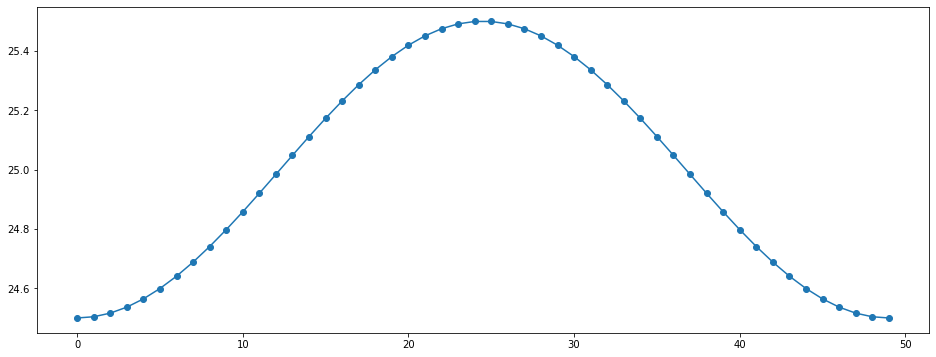

In [15]:
# plot initial profile
x = np.arange(0, domain_size[0], 1)   # start,stop,step
y = fluid_depth + amplitude * np.cos(x / (domain_size[0] - 1) * np.pi * 2 + np.pi)

plt.plot(x,y, marker='o')
plt.show()

In [16]:
initialize_phasefield()

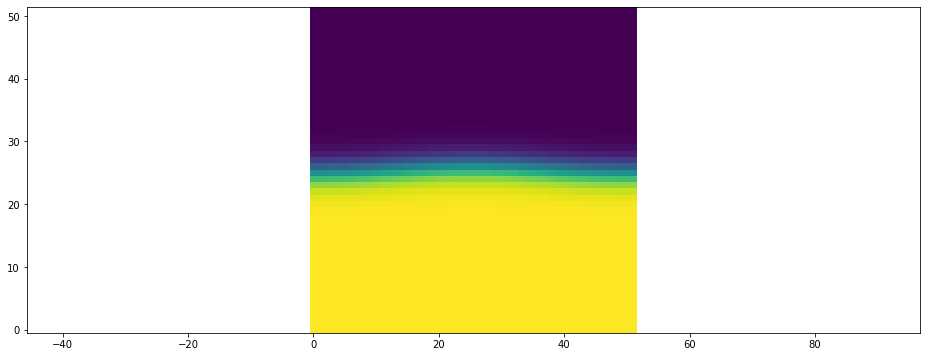

In [17]:
plt.scalar_field(dh.cpu_arrays["C"])
plt.show()

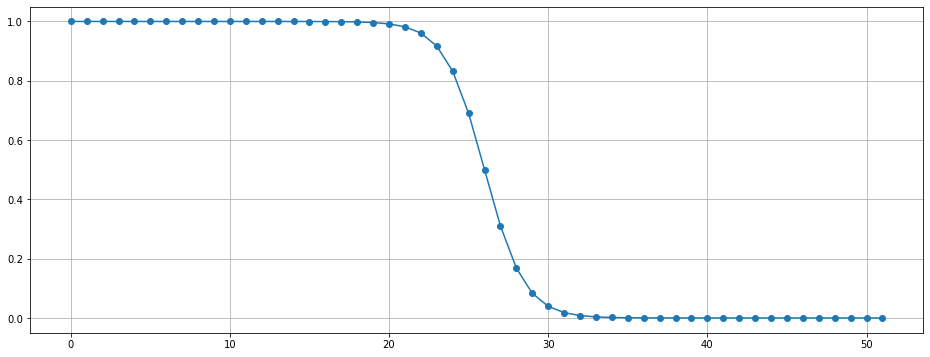

In [18]:
# plot initial interface profile
x = np.arange(0, domain_size[1]+2, 1)   # start,stop,step
y = dh.cpu_arrays["C"][int(domain_size[0] * 0.5), :]

plt.plot(x,y, marker='o')
plt.grid()
plt.show()

In [19]:
force_h = interface_tracking_force(C, stencil_phase, parameters)
hydro_force = hydrodynamic_force(g, C, method_hydro, parameters, body_force)

## Definition of the LB update rules

In [20]:
lbm_optimisation = LBMOptimisation(symbolic_field=h, symbolic_temporary_field=h_tmp)
allen_cahn_update_rule = create_lb_update_rule(lbm_config=config_phase,
                                               lbm_optimisation=lbm_optimisation)

allen_cahn_update_rule = add_interface_tracking_force(allen_cahn_update_rule, force_h)

ast_kernel = ps.create_kernel(allen_cahn_update_rule, target=dh.default_target, cpu_openmp=True)
kernel_allen_cahn_lb = ast_kernel.compile()

[['spatialInner0'], ['spatialInner1']]


In [21]:
force_Assignments = hydrodynamic_force_assignments(g, u, C, method_hydro, parameters, body_force)

lbm_optimisation = LBMOptimisation(symbolic_field=g, symbolic_temporary_field=g_tmp)
hydro_lb_update_rule = create_lb_update_rule(lbm_config=config_hydro,
                                             lbm_optimisation=lbm_optimisation)

hydro_lb_update_rule = add_hydrodynamic_force(hydro_lb_update_rule, force_Assignments, C, g, parameters)

ast_kernel = ps.create_kernel(hydro_lb_update_rule, target=dh.default_target, cpu_openmp=True)
kernel_hydro_lb = ast_kernel.compile()

[['spatialInner0'], ['spatialInner1']]


## Boundary Conditions

In [22]:
# periodic Boundarys for g, h and C
periodic_BC_C = dh.synchronization_function(C.name, target=dh.default_target, optimization = {"openmp": True})

periodic_BC_g = LBMPeriodicityHandling(stencil=stencil_hydro, data_handling=dh, pdf_field_name=g.name,
                                       streaming_pattern='push')
periodic_BC_h = LBMPeriodicityHandling(stencil=stencil_phase, data_handling=dh, pdf_field_name=h.name,
                                       streaming_pattern='pull')

# No slip boundary for the phasefield lbm
bh_allen_cahn = LatticeBoltzmannBoundaryHandling(method_phase, dh, 'h',
                                                 target=dh.default_target, name='boundary_handling_h',
                                                 streaming_pattern='pull')

# No slip boundary for the velocityfield lbm
bh_hydro = LatticeBoltzmannBoundaryHandling(method_hydro, dh, 'g' ,
                                            target=dh.default_target, name='boundary_handling_g',
                                            streaming_pattern='push')

contact_angle = BoundaryHandling(dh, C.name, stencil_hydro, target=dh.default_target)
contact = ContactAngle(90, interface_width)

wall = NoSlip()
if dimensions == 2:
    bh_allen_cahn.set_boundary(wall, make_slice[:, 0])
    bh_allen_cahn.set_boundary(wall, make_slice[:, -1])

    bh_hydro.set_boundary(wall, make_slice[:, 0])
    bh_hydro.set_boundary(wall, make_slice[:, -1])
    
    contact_angle.set_boundary(contact, make_slice[:, 0])
    contact_angle.set_boundary(contact, make_slice[:, -1])
else:
    bh_allen_cahn.set_boundary(wall, make_slice[:, 0, :])
    bh_allen_cahn.set_boundary(wall, make_slice[:, -1, :])

    bh_hydro.set_boundary(wall, make_slice[:, 0, :])
    bh_hydro.set_boundary(wall, make_slice[:, -1, :])
    
    contact_angle.set_boundary(contact, make_slice[:, 0, :])
    contact_angle.set_boundary(contact, make_slice[:, -1, :])


bh_allen_cahn.prepare()
bh_hydro.prepare()
contact_angle.prepare()

## Full timestep

In [23]:
# definition of the timestep for the immiscible fluids model
def timeloop():
    # Solve the interface tracking LB step with boundary conditions
    periodic_BC_h()
    bh_allen_cahn()    
    dh.run_kernel(kernel_allen_cahn_lb, **parameters.symbolic_to_numeric_map)
    dh.swap("C", "C_tmp")
    
    # apply the three phase-phase contact angle
    contact_angle()
    # periodic BC of the phase-field
    periodic_BC_C()
    
    # solve the hydro LB step with boundary conditions
    dh.run_kernel(kernel_hydro_lb, **parameters.symbolic_to_numeric_map)
    periodic_BC_g()
    bh_hydro()
    
    # compute density (only for vtk output)
    # must be done BEFORE swapping fields to avoid having outdated values
    compute_density()
    
    # field swaps
    dh.swap("h", "h_tmp")
    dh.swap("g", "g_tmp")

In [24]:
def initialize_hydrostatic_pressure():   
    for block in dh.iterate(ghost_layers=True, inner_ghost_layers=False):       
        
        # get y as cell center coordinate, i.e., including shift with 0.5
        y = np.zeros_like(block.midpoint_arrays[1])
        y[:, :] = block.midpoint_arrays[1]
        
        # compute hydrostatic density
        rho_hydrostatic = 1 + 3 * gravitational_acceleration * (y - fluid_depth)
        
        # subtract 1 because PDFs in incompressible LBM are centered around zero in lbmpy
        rho_hydrostatic -= 1

        # set equilibrium PDFs with velocity=0 and rho; 
        for i in range(0, stencil_hydro.Q, 1):
            block["g"][:,:,i] = method_hydro.weights[i] * rho_hydrostatic[:,:]
            block["g_tmp"][:,:,i] = method_hydro.weights[i] * rho_hydrostatic[:,:]

In [25]:
def compute_density():   
    for block in dh.iterate(ghost_layers=True, inner_ghost_layers=False):
        # PDFs in incompressible LBM are centered around zero in lbmpy
        # => add 1 to whole sum, i.e., initialize with 1
        block["rho"].fill(1);
        
        # compute density
        for i in range(block["g"].shape[-1]):
            block["rho"][:,:] += block["g"][:,:,i]

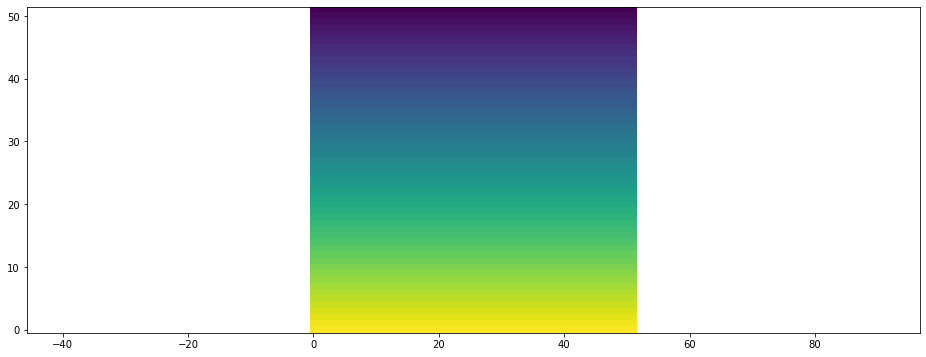

In [26]:
if (gravitational_acceleration != 0):
    initialize_hydrostatic_pressure()
    compute_density()
    plt.scalar_field(dh.cpu_arrays["rho"])

In [27]:
print("================================= start of the simulation ===================================")

start = time.time()

pbar = tqdm(total=timesteps)

timestep = []
surface_position = []
symmetry_norm = []
mass = []

for i in range(0, timesteps):
    
    sum_c_2 = 0.0
    sum_delta_c_2 = 0.0
    
    # write vtk output
    if(i % vtk_output_frequency == 0):
        if gpu:
            dh.to_cpu("C")
            dh.to_cpu("u")
            dh.to_cpu("rho")
        vtk_writer(i)
    
    # extract data (to be written to file)
    if(i % data_extract_frequency == 0):
        pbar.update(data_extract_frequency)
            
        timestep.append(i)
        
        ny = domain_size[1]

        # get index containing phase field value < 0.5
        i1 = np.argmax(dh.cpu_arrays["C"][int(domain_size[0] * 0.5), :] < 0.5)
        i0 = i1 - 1 # index containing phase field value >= 0.5    

        f0 = dh.cpu_arrays["C"][int(domain_size[0] * 0.5), i0] # phase field value >= 0.5
        f1 = dh.cpu_arrays["C"][int(domain_size[0] * 0.5), i1] # phase field value < 0.5

        # coordinate of cell center is index+0.5-1 (0.5 to get to cell center; -1 to remove ghost layer from index)
        y0 = i0 + 0.5 - 1
        y1 = i1 + 0.5 - 1

        #interpolate
        surface_position.append( y0 + (y1 - y0) / (f1 - f0) * (0.5 - f0) )
        
        # evaluate symmetry in x-direction
        for y in range(0, domain_size[1] - 1):
            for x in range(0, domain_size[0] - 1):
                if (x >= domain_size[0] * 0.5):
                    continue
                    
                x_mirrored = domain_size[0] - 1 - x;
                sum_c_2 += dh.cpu_arrays["C"][x, y]**2
                sum_delta_c_2 += (dh.cpu_arrays["C"][x, y] - dh.cpu_arrays["C"][x_mirrored, y])**2
                
        symmetry_norm.append( (sum_delta_c_2 / sum_c_2)**2 )
        
        mass.append(np.sum(dh.cpu_arrays["C"]))
        
    timeloop()

pbar.close()
end = time.time()
sim_time = end - start
print("\n")
print("time needed for the calculation: %4.4f" % sim_time , "seconds")

nrOfCells = np.prod(domain_size)
mlups = nrOfCells * timesteps / sim_time * 1e-6

print("MLUPS: %4.2f" % mlups)

================================= start of the simulation ===================================


  0%|          | 0/238800 [00:00<?, ?it/s]



time needed for the calculation: 99.6110 seconds
MLUPS: 5.99


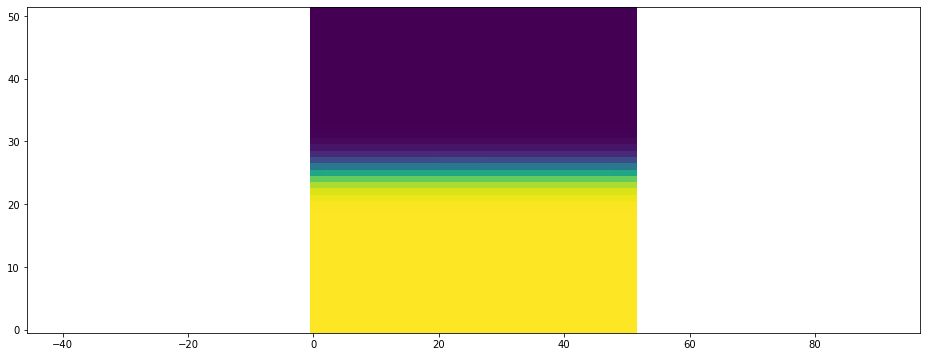

In [28]:
if gpu:
    dh.to_cpu("C")
    dh.to_cpu("u")
    dh.to_cpu("rho")

plt.scalar_field(dh.cpu_arrays["C"])

In [29]:
# non-dimensionalize time and surface position
t_nd = [value * wave_frequency for value in timestep]
a_nd = [(value - fluid_depth) / amplitude for value in surface_position]

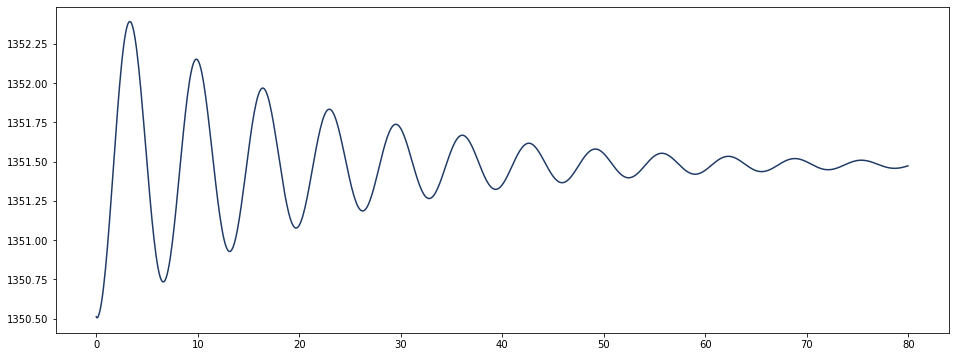

In [30]:
plt.plot(t_nd, mass, color=(0.121, 0.231, 0.4))
plt.show()

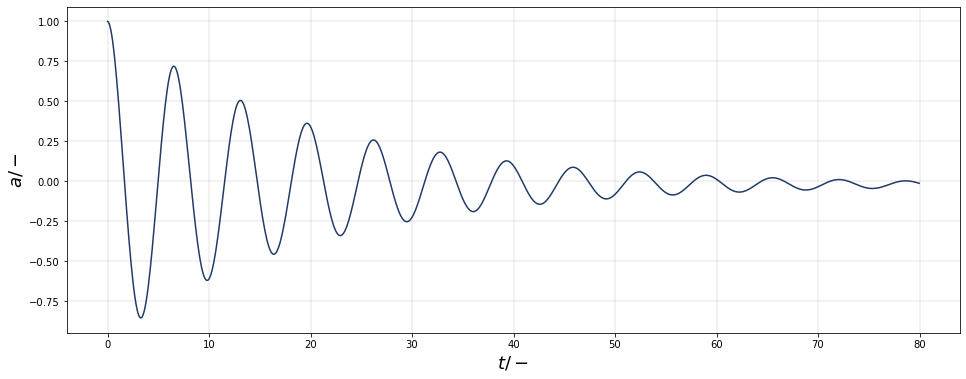

In [31]:
# plot surface position over time
plt.xlabel('$t/-$', fontsize=18)
plt.ylabel('$a/-$', fontsize=18)
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.plot(t_nd, a_nd, color=(0.121, 0.231, 0.4))
plt.show()

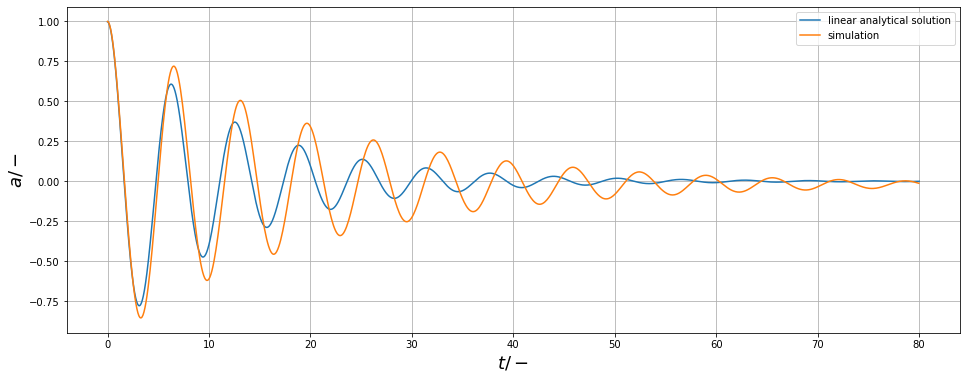

In [32]:
# plot analytical solutions
x = 0.5 # position where surface elevation is evaluated;
        # 0.5 means center of first cell;
        # amplitude of analytical solution is at 0 (not in domain center)

t = np.arange(0, timesteps, 1)
a = amplitude * np.exp(-2 * kinematic_viscosity_heavy * wavenumber**2 * t) # damping of wave amplitude

# linear analytical solution
a_anal_lin = a * np.cos(wavenumber * x - wave_frequency * t) + fluid_depth

# non-linear analytical solution
a_anal_nonlin = (a * np.cos(wavenumber * x - wave_frequency * t) + 
                        wavenumber * a**2 * 0.5 * 
                        (1 + 3 / (2 * np.sinh(wavenumber * fluid_depth)**2)) * 
                        1 / np.tanh(wavenumber * fluid_depth) * 
                        np.cos(2 * wavenumber * x - 2 * wave_frequency * t) + fluid_depth)

# non-dimesionalize time and surface position
a_anal_lin_nd = (a_anal_lin - fluid_depth) / amplitude
a_anal_nonlin_nd = (a_anal_nonlin - fluid_depth) / amplitude
t_anal_nd = t * wave_frequency

plt.plot(t_anal_nd, a_anal_lin_nd, label="linear analytical solution")
#plt.plot(t_anal_nd, a_anal_nonlin_nd, label="nonlinear analytical solution")
plt.plot(t_nd, a_nd, label="simulation")
plt.xlabel('$t/-$', fontsize=18)
plt.ylabel('$a/-$', fontsize=18)
plt.legend()
plt.grid()
plt.show()

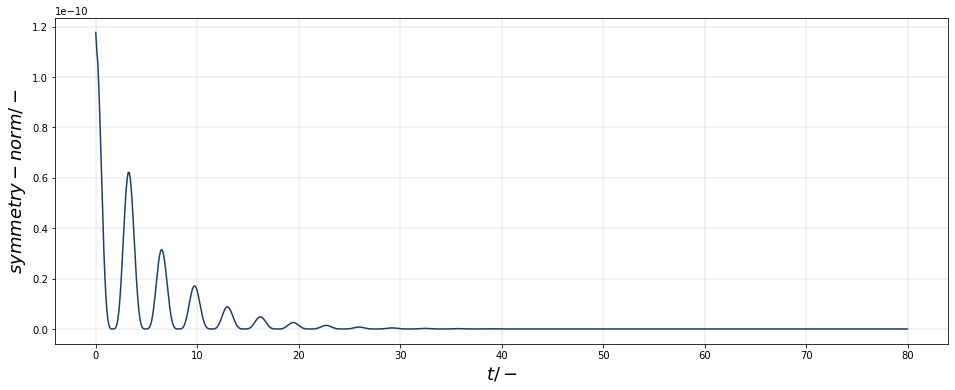

In [33]:
# plot symmetry norm over time
plt.xlabel('$t/-$', fontsize=18)
plt.ylabel('$symmetry-norm/-$', fontsize=18)
plt.grid(color='black', linestyle='-', linewidth=0.1)
plt.plot(t_nd, symmetry_norm, color=(0.121, 0.231, 0.4))
plt.show()

In [34]:
# store results to file
import csv
with open(filename, 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerows(zip(t_nd, a_nd, symmetry_norm))